In [1]:
#import useful packages
import keras
import pandas as pd
from keras.models import Sequential
import numpy as np
import keras.backend as kb
import tensorflow as tf
import matplotlib.pyplot as plt
import statistics as stat
from sklearn.model_selection import train_test_split
from keras import backend as K


#the following 2 lines are only needed for Mac OS machines
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import pandas as pd

Using TensorFlow backend.


## Data Processing
First step is dataprocessing:
+ Join Epidemiology and Vaccination data set on 'date'
+ Filter for US data
+ Only keep the following features: 'new_confirmed' (nr daily covid cases), 'new_deceased' (nr of daily covid deaths), 'cumulative_persons_vaccinated' (cummulative nr of vaccinated poeple)
+ Convert from daily to weekly data
+ Normalize data
+ Convert data into 3D matrix (which can be interpreted by RNN/LSTM network

In [2]:
dataepid = pd.read_csv('epidemiology.csv')
datavacc = pd.read_csv('vaccinations.csv')
USmean_std = [6957.943661971831,5448.9152148001085] #Mean and standard deviation of the weekly number of covid deaths

In [3]:
def data_preprocessing(Country):
    dataepidcountry = dataepid.query('location_key=="'+Country+'"')
    dataepidcountry =dataepidcountry[['date','new_confirmed','new_deceased']]
    print('dataepid ' + Country+ ' shape',dataepidcountry.shape)
    
    datavacccountry = datavacc.query('location_key=="'+Country+'"')[['date','cumulative_persons_vaccinated']]
    print('datavacc' + Country+ ' shape',datavacccountry.shape)
    
    datacountry = dataepidcountry.merge(datavacccountry, on='date', how='left').fillna({'cumulative_persons_vaccinated':0.0})
    print('data' + Country+ ' shape',datacountry.shape)
    
    Countrydataday = datacountry[['date','new_confirmed','new_deceased','cumulative_persons_vaccinated']]
    Countrydataday['date'] = Countrydataday['date'].astype('datetime64[ns]')
    weekly_datacountry = Countrydataday.resample('W-Wed', label='right', closed = 'right', on='date').sum().reset_index().sort_values(by='date')
    Countrydataweek = np.array(weekly_datacountry[['new_confirmed','new_deceased','cumulative_persons_vaccinated']])
    
    print('shape weekly data:',Countrydataweek.shape)
    
    Countrydata_norm = np.empty((Countrydataweek.shape[0],Countrydataweek.shape[1]))

    mean0 = stat.mean(Countrydataweek[:,0]) #covid cases
    mean1 = stat.mean(Countrydataweek[:,1]) #covid deaths
    mean2 = stat.mean(Countrydataweek[:,2]) #vaccination cummulative

    std0 = stat.stdev(Countrydataweek[:,0])
    std1 = stat.stdev(Countrydataweek[:,1])
    std2 = stat.stdev(Countrydataweek[:,2])

    for i in range(len(Countrydataweek)):
        Countrydata_norm[i][0] = (Countrydataweek[i][0] - mean0)/std0
        Countrydata_norm[i][1] = (Countrydataweek[i][1] - mean1)/std1
        Countrydata_norm[i][2] = (Countrydataweek[i][2] - mean2)/std2
    
    Countrydata_norm = Countrydata_norm[0:139,:]
    
    return Countrydata_norm

In [4]:
def inpsect_data(Countrydata_norm):
    x = np.linspace(0,Countrydata_norm.shape[0],Countrydata_norm.shape[0])
    fig = plt.figure()
    plt.plot(x,Countrydata_norm[:,0])
    plt.plot(x,Countrydata_norm[:,1])
    plt.plot(x,Countrydata_norm[:,2])
    plt.legend(['cases','deceased','cumulative vaccinations'])
    plt.xlabel('week')
    plt.title('Weekly Data (Normalized)')
    return fig

dataepid US shape (988, 3)
datavaccUS shape (643, 2)
dataUS shape (988, 4)
shape weekly data: (142, 3)


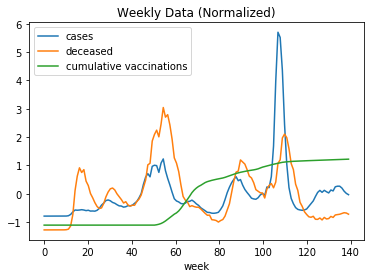

In [5]:
USdata_norm = data_preprocessing('US')
fig = inpsect_data(USdata_norm)

In [6]:
def convert2matrix(data_arr, look_back):
    X, Y =np.empty((data_arr.shape[0]-look_back,look_back, 3)), np.empty((data_arr.shape[0]-look_back,1))
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X[i,:,0] = data_arr[i:d,0]
        X[i,:,1] = data_arr[i:d,1]
        X[i,:,2] = data_arr[i:d,2]
        Y[i,0] = data_arr[d,1]
    return np.array(X), np.array(Y)

In [7]:
look_back = 5
X,Y = convert2matrix(USdata_norm,look_back)
print('X shape',X.shape,'Y shape',Y.shape)

X_train, X_valid, y_train, y_valid = train_test_split(X,Y,test_size=0.25)


# print(X[129,:,1],Y[-1,0])
# print(USdataweek[129:,1])
# train_len = 100
# X_train, y_train = X[:train_len,:,:],Y[:train_len,:]
# X_valid, y_valid = X[train_len:,:,:],Y[train_len:,:]
# # X_test, y_test = X[125:,:,:],Y[125:,:]
print('Training data shape : ', X_train.shape, y_train.shape)
print('Validation data shape : ', X_valid.shape, y_valid.shape)

X shape (134, 5, 3) Y shape (134, 1)
Training data shape :  (100, 5, 3) (100, 1)
Validation data shape :  (34, 5, 3) (34, 1)


## Model Training


In [ ]:
import time

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

#initialize weights with values between -0.2 and 1.2

es = keras.callbacks.EarlyStopping(
    monitor='loss', 
    mode='min', 
    patience = 50, 
    restore_best_weights = True, 
    verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="loss",
    factor=0.5,
    patience=35,
    verbose=0,
    min_delta=0.000001,
    min_lr=0.000001)

average_losses={}
average_times ={}
average_valloss = {}
smallest_loss = {}
nrofmodels = 4
nrofiterations = 4 #average over nrofiterations per model
nrepochs = 500
dropout_frac = 0.25

for k in range(nrofiterations):
    total_loss_currmodel = np.zeros(nrepochs)
    total_times = np.zeros(nrepochs)
    
    
    
    for m in range(nrofmodels):
        
        if k ==0:
            average_losses['Model'+str(m)] =np.zeros(nrepochs)
            average_times['Model'+str(m)] =np.zeros(nrepochs)
            average_valloss['Model'+str(m)] =np.zeros(nrepochs)
            smallest_loss['Model'+str(m)] =np.zeros(2)

        
        print('Nr of ITERATIONS:',k+1,'/', nrofiterations,'Model nr:', m+1,'/',nrofmodels)
        
        if m == 0:
            model = keras.models.Sequential([keras.layers.LSTM(10,
                return_sequences=True, input_shape=[None, 3]),
                keras.layers.LSTM(10),
                keras.layers.Dense(5),
                keras.layers.Dense(1)]) 

        if m == 1:
            model = keras.models.Sequential([keras.layers.LSTM(10,
                return_sequences=True, input_shape=[None, 3]),
                keras.layers.Dropout(dropout_frac),
                keras.layers.LSTM(10),
                keras.layers.Dropout(dropout_frac),
                keras.layers.Dense(5),
                keras.layers.Dense(1)]) 
            
        if m == 2:
            model = keras.models.Sequential([
                keras.layers.SimpleRNN(1, input_shape=[None, 3]),
                ])
        
        if m == 3:
             model = keras.models.Sequential([
                keras.layers.Flatten(input_shape=[5, 3]),
                keras.layers.Dense(1)])
                
                
#         if m == 2:
#             model = keras.models.Sequential([keras.layers.LSTM(30,
#                 return_sequences=True, input_shape=[None, 3]),
#                 keras.layers.LSTM(30),
#                 keras.layers.Dense(20),
#                 keras.layers.Dense(20),
#                 keras.layers.Dense(1)]) 
                
#         if m == 3:
#              model = keras.models.Sequential([keras.layers.LSTM(100,
#                 return_sequences=True, input_shape=[None, 3]),
#                 keras.layers.LSTM(100),
#                 keras.layers.Dense(50),
#                 keras.layers.Dense(50),
#                 keras.layers.Dense(1)]) 
        
             


        rms = keras.optimizers.RMSprop(learning_rate = 0.05)
        model.compile(loss='mean_absolute_error',optimizer=rms)
            
        mc = keras.callbacks.ModelCheckpoint('best_model.SB', monitor='loss', 
                     mode='min',  verbose=1, save_best_only=True)
            
        time_callback = TimeHistory()

        historyData = model.fit(X_train,y_train,epochs=nrepochs,callbacks=[reduce_lr,time_callback],\
                                    validation_data=(X_valid, y_valid),verbose=1)
        
        best_epoch = np.argmin(historyData.history['loss']) + 1
        
        loss_hist_curr = np.array(historyData.history['loss'])
        times_curr = np.array(time_callback.times)
        val_loss_curr = np.array(historyData.history['val_loss'])
        smallest_loss_curr = np.array((np.min(loss_hist_curr),np.min(val_loss_curr)))
        

        average_losses['Model'+str(m)] = average_losses['Model'+str(m)]+ loss_hist_curr
        average_times['Model'+str(m)] = average_times['Model'+str(m)]+ times_curr
        average_valloss['Model'+str(m)] = average_valloss['Model'+str(m)]+ val_loss_curr
        smallest_loss['Model'+str(m)] = smallest_loss['Model'+str(m)] + smallest_loss_curr

        
for m in range(nrofmodels):
    average_losses['Model'+str(m)] = average_losses['Model'+str(m)]/nrofiterations
    average_times['Model'+str(m)] = average_times['Model'+str(m)]/nrofiterations
    average_valloss['Model'+str(m)] = average_valloss['Model'+str(m)]/nrofiterations
    smallest_loss['Model'+str(m)] = smallest_loss['Model'+str(m)]/nrofiterations

Nr of ITERATIONS: 1 / 4 Model nr: 1 / 4
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Train on 100 samples, validate on 34 samples
Epoch 1/500
100/100 [==============================] - 1s 9ms/step - loss: 0.9423 - val_loss: 0.6724
Epoch 2/500
100/100 [==============================] - 0s 378us/step - loss: 0.6054 - val_loss: 0.5269
Epoch 3/500
100/100 [==============================] - 0s 542us/step - loss: 0.5079 - val_loss: 0.5002
Epoch 4/500
100/100 [==============================] - 0s 624us/step - loss: 0.4527 - val_loss: 0.3272
Epoch 5/500
100/100 [==============================] - 0s 377us/step - loss: 0.4124 - val_loss: 0.2007
Epoch 6/500
100/100 [==============================] - 0s 350us/step - loss: 0.4188 - val_loss: 0.2952
Epoch 7/500
100/100 [==============================] - 0s 377us/step - loss: 0.3443 - val_loss: 0.4765
Epoch 8/500
100/100 [==============================] - 0s 314us/step - loss: 0.4336 - val_loss: 0.7748
Epoch 9/500
100/100 [==============================] - 0s 415us/step - loss: 0.4119 - val_loss: 0.3927
Epoch 10/500
100/100 [========

In [ ]:
# model.save('./best_model')
# recon_model = keras.models.load_model("best_model")

In [ ]:
print('Final losses [TrainingLoss  ValidationLoss]:')
for m in range(nrofmodels):
    print('MODEL:',m)
    print('         Minimal MAE Loss', smallest_loss['Model'+str(m)],\
          ',difference rel=',\
          round(-(average_losses['Model'+str(m)][-1]-average_valloss['Model'+str(m)][-1])/average_losses['Model'+str(m)][-1],3),
         ',difference abs=',\
          round(-(average_losses['Model'+str(m)][-1]-average_valloss['Model'+str(m)][-1]),3))

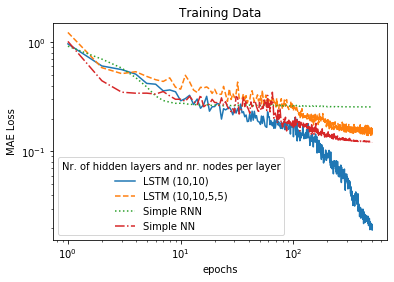

In [11]:
epochsx = np.linspace(1,nrepochs,nrepochs)
start = 0
plt.plot(epochsx[start:len(average_losses['Model0'])],average_losses['Model0'][start:])
plt.plot(epochsx[start:len(average_losses['Model1'])],average_losses['Model1'][start:],linestyle='dashed')
plt.plot(epochsx[start:len(average_losses['Model2'])],average_losses['Model2'][start:],linestyle='dotted')
plt.plot(epochsx[start:len(average_losses['Model3'])],average_losses['Model3'][start:],linestyle='dashdot')
plt.loglog()
plt.title('Training Data')
plt.legend(['LSTM (10,10)','LSTM (10,10,5,5)','Simple RNN','Simple NN'],title='Nr. of hidden layers and nr. nodes per layer')
plt.xlabel('epochs')
plt.ylabel('MAE Loss')
# plt.savefig('modelcompTrain',dpi=300)
plt.show()

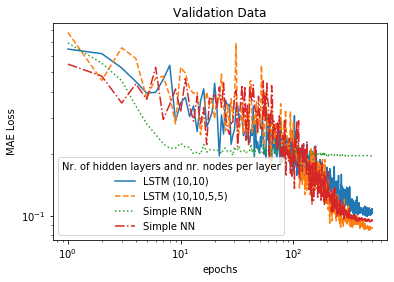

In [12]:
epochsx = np.linspace(1,nrepochs,nrepochs)
start = 0
plt.plot(epochsx[start:len(average_valloss['Model0'])],average_valloss['Model0'][start:])
plt.plot(epochsx[start:len(average_valloss['Model1'])],average_valloss['Model1'][start:],linestyle='dashed')
plt.plot(epochsx[start:len(average_valloss['Model2'])],average_valloss['Model2'][start:],linestyle='dotted')
plt.plot(epochsx[start:len(average_valloss['Model3'])],average_valloss['Model3'][start:],linestyle='dashdot')
plt.loglog()
plt.legend(['LSTM (10,10)','LSTM (10,10,5,5)','Simple RNN','Simple NN'],title='Nr. of hidden layers and nr. nodes per layer')
plt.xlabel('epochs')
plt.ylabel('MAE Loss')
plt.title('Validation Data')
# plt.savefig('modelcompval',dpi=300)
plt.show()

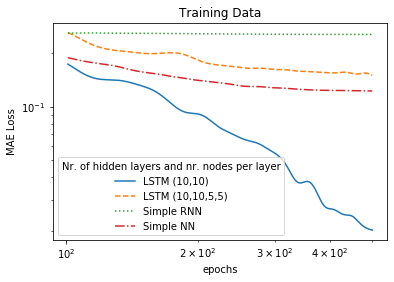

In [13]:
import scipy.signal
start =100
# print(len(data))
b, a = scipy.signal.butter(3, 0.05)
filtered0 = scipy.signal.filtfilt(b,a, average_losses['Model0'][start:])
filtered1 = scipy.signal.filtfilt(b,a, average_losses['Model1'][start:])
filtered2 = scipy.signal.filtfilt(b,a, average_losses['Model2'][start:])
filtered3 = scipy.signal.filtfilt(b,a, average_losses['Model3'][start:])

plt.figure()
plt.plot(epochsx[start:],filtered0)
plt.plot(epochsx[start:],filtered1,linestyle='dashed')
plt.plot(epochsx[start:],filtered2,linestyle='dotted')
plt.plot(epochsx[start:],filtered3,linestyle='dashdot')
plt.legend(['LSTM (10,10)','LSTM (10,10,5,5)','Simple RNN','Simple NN'],title='Nr. of hidden layers and nr. nodes per layer')
plt.xlabel('epochs')
plt.ylabel('MAE Loss')
plt.title('Training Data')
plt.loglog()
# plt.savefig('modelcompTrainfilt',dpi=300)
plt.show()

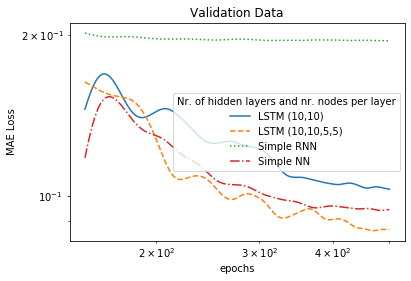

In [14]:
start =150
# print(len(data))
b, a = scipy.signal.butter(3, 0.05)
filtered0 = scipy.signal.filtfilt(b,a, average_valloss['Model0'][start:])
filtered1 = scipy.signal.filtfilt(b,a, average_valloss['Model1'][start:])
filtered2 = scipy.signal.filtfilt(b,a, average_valloss['Model2'][start:])
filtered3 = scipy.signal.filtfilt(b,a, average_valloss['Model3'][start:])

plt.figure()
plt.plot(epochsx[start:],filtered0)
plt.plot(epochsx[start:],filtered1,linestyle='dashed')
plt.plot(epochsx[start:],filtered2,linestyle='dotted')
plt.plot(epochsx[start:],filtered3,linestyle='dashdot')
plt.legend(['LSTM (10,10)','LSTM (10,10,5,5)','Simple RNN','Simple NN'],title='Nr. of hidden layers and nr. nodes per layer')
plt.xlabel('epochs')
plt.ylabel('MAE Loss')
plt.title('Validation Data')
plt.loglog()
plt.savefig('modelcompvalfilt',dpi=300)
plt.show()

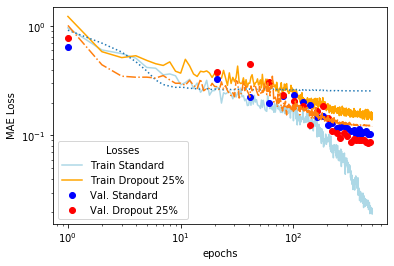

In [15]:
epochsx = np.linspace(1,nrepochs,nrepochs)
start = 0
interval = 20
plt.plot(epochsx[start:len(average_losses['Model0'])],average_losses['Model0'][start:],color = 'lightblue')
plt.plot(epochsx[start:len(average_losses['Model1'])],average_losses['Model1'][start:],color= 'orange')
plt.plot(epochsx[start:len(average_valloss['Model0'])][0::interval],average_valloss['Model0'][start:][0::interval],\
         'o',color='blue')
plt.plot(epochsx[start:len(average_valloss['Model1'])][0::interval],average_valloss['Model1'][start:][0::interval],\
         'o', color= 'red')
plt.plot(epochsx[start:len(average_losses['Model2'])],average_losses['Model2'][start:],linestyle='dotted')
plt.plot(epochsx[start:len(average_losses['Model3'])],average_losses['Model3'][start:],linestyle='dashdot')
plt.loglog()
# plt.legend(['(8,20,20,20,20,20)','(8,30,30,30,30,30,30)','(8,20,20,20,20,20,20,20,20)','(8,100,100,100,100,100,100)'],title='Nr. of hidden layers and nr. nodes per layer')
# plt.legend(['(6,8,16,8)','(6,6)','(8,8,8,8,8,8)', '(8,20,20,20,20,20,20)'],title='Nr. of hidden layers and nr. nodes per layer')
plt.legend(['Train Standard','Train Dropout 25%','Val. Standard','Val. Dropout 25%'],title='Losses')
plt.xlabel('epochs')
plt.ylabel('MAE Loss')
# plt.savefig('modelcompT2dropout',dpi=300)
plt.show()

In [16]:
total_time = 0

for i in range(nrofmodels):
    print('MODEL:',i)
    totaltime_currmod = np.sum(average_times['Model'+str(i)][1:])
#     averagetime_currmod = totaltime_currmod/nrepochs
    averagetime_currmod = totaltime_currmod/len(average_times['Model'+str(i)][1:])
    print('         Average time', averagetime_currmod)
    print('         Total time',totaltime_currmod)
    total_time += totaltime_currmod*nrofiterations
print('Total time [min]',total_time/60)

MODEL: 0
         Average time 0.04174329367333758
         Total time 20.829903542995453
MODEL: 1
         Average time 0.04079916446146841
         Total time 20.358783066272736
MODEL: 2
         Average time 0.023527195076187533
         Total time 11.740070343017578
MODEL: 3
         Average time 0.015796245338921558
         Total time 7.882326424121857
Total time [min] 4.054072225093842


## Prediction
The performance of the trained model is now verified by looking to its ability in predicting the weekly covid deceases
+ Y_real = real number of covid deaths (from original dataset)
+ Y_pred = predicted number of covid deaths. In this prediction method, the newly predicted value is based on the previously predicted value
+ Y_predv2 = predicted number of covid deaths. In this prediction method the original (true) data was used

In [17]:
def forecasting(X,Y,start=0):
    global USmean_std
    totalsteps = X.shape[0]-start
    Ypred = np.zeros(totalsteps)
    Ypredv2 = np.zeros(totalsteps)
    Yreal = np.zeros(totalsteps)
    Xinit = X[start,:,:]
    Xinit = Xinit[np.newaxis,:,:]

    for step in range (totalsteps):
        Xcurrv2 = X[start+step,:,:]
        Xcurrv2 = Xcurrv2[np.newaxis,:,:]
        if step ==0 :
            Xcurr = Xinit
        if step != 0:
            Xprev = Xcurr
    #         print(Xcurr[0,-1,1] , Ypredcurr,Yrealcurr)
            Xcurr = np.zeros((1,X.shape[1],X.shape[2]))
            Xcurr[0,:,0] = X[start+step,:,0]
            Xcurr[0,:,2] = X[start+step,:,2]
            Xcurr[0,0:look_back-1,1] = Xprev[0,1:,1]
            Xcurr[0,-1,1] = Ypredcurr
        Yrealcurr = Y[start+step,:]
        Ypredcurr = model.predict(Xcurr,verbose=0)
        Ypredcurrv2 = model.predict(Xcurrv2,verbose=0)
        
        Yreal[step] = Yrealcurr*USmean_std[1]+USmean_std[0]
        Ypred[step] = Ypredcurr*USmean_std[1]+USmean_std[0]
        Ypredv2[step] = Ypredcurrv2*USmean_std[1]+USmean_std[0]
#         Yreal[step] = Yrealcurr*deaths_med
#         Ypred[step] = Ypredcurr*deaths_med
#         Ypredv2[step] = Ypredcurrv2*deaths_med
    
    xaxis = np.linspace(start,start+totalsteps-1,totalsteps)
    fig = plt.figure()
    plt.plot(xaxis,Yreal)
    plt.plot(xaxis,Ypred,linestyle='dotted')
    plt.plot(xaxis,Ypredv2,linestyle='dashdot',linewidth=1.0)
    plt.legend(['Y_real', 'Y_pred','Y_predv2'], loc='upper right')
    plt.ylabel('Y, Ypred')
    plt.xlabel('Week')

    return Yreal,Ypred,Ypredv2,fig





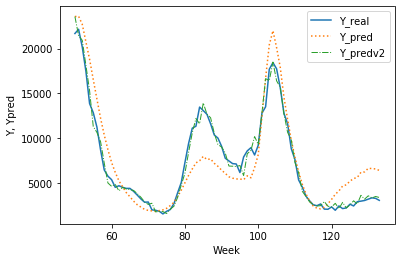

In [18]:
sol =  forecasting(X,Y,start=50)
Yreal,Ypred,Ypredv2 = sol[0],sol[1],sol[2]

## Prediction Using US Model for New Countries
This section discovers how the model which was trained on US data performs in predicting the covid deceases of new countries

dataepid FR shape (989, 3)
datavaccFR shape (627, 2)
dataFR shape (989, 4)
shape weekly data: (143, 3)


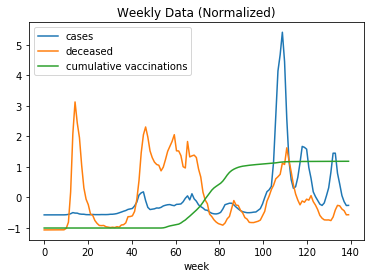

In [19]:
FRdata_norm = data_preprocessing('FR')
fig = inpsect_data(FRdata_norm)


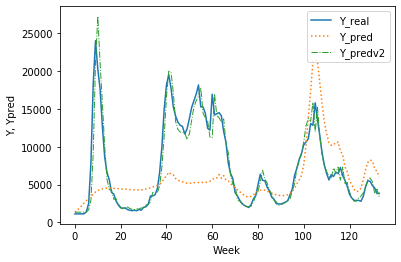

In [20]:
XFR,YFR = convert2matrix(FRdata_norm,look_back)
sol =  forecasting(XFR,YFR,start=0)
Yreal,Ypred,Ypredv2 = sol[0],sol[1],sol[2]